# Trading at the Close - Feature Engineering
-----------------------

Feature selection involves picking the set of features that are most relevant to the target variable. This helps in reducing the complexity of the model, as well as minimizing the resources required for training and inference. This has greater effect in production models where one maybe dealing with terabytes of data or serving millions of requests.

Most of the modules will come from [scikit-learn](https://scikit-learn.org/stable/), one of the most commonly used machine learning libraries. It features various machine learning algorithms and has built-in implementations of different feature selection methods. Using these, you will be able to compare which method works best for this particular dataset.

## Installs

In [89]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Imports

In [61]:
# for data processing and manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# scikit-learn modules for feature selection and model evaluation
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from itertools import combinations

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

## Define the Configuration

This cell defines the configuration to use throughout this notebook for feature selection.

In [62]:
class CFG:
    TRAINING_PATH_CSV = Path(".", "train_files", "train.csv")
    TRAINING_PATH_PARQUET = Path(".", "train_files", "train.parquet")
    RANDOM_STATE = 123
    N_FOLDS = 5
    USE_GPU = True
    SCALE = False # Tree-based models are invariant to feature scaling
    SCALER = StandardScaler
    STRATIFY = False
    TIME_AWARE_SPLIT = True
    MODEL = LGBMRegressor
    MODEL_CONFIG = {
        "device"            : "gpu" if USE_GPU else "cpu",
        "objective"         : "regression_l1",
        "boosting_type"     : "gbdt",
        "random_state"      : RANDOM_STATE,
        #"subsample_for_bin" : 500000, 
        #"colsample_bytree"  : 0.7,
        #"subsample"         : 0.65,
        #"learning_rate"     : 0.065,
        #"max_depth"         : 6,
        #"n_estimators"      : 700,
        #"num_leaves"        : 150,  
        #"reg_alpha"         : 0.05,
        #"reg_lambda"        : 3.25,
        #"verbose"           : -1,
    }
    RFE_FEAT_COUNT = 10
    FEAT_FIMPORT_COUNT= 10

## Define Helper Functions

The following cells define helper functions for diverse tasks such as memory footprint reduction and feature creation.

In [63]:
def downcast(df):
    '''This function downcasts the elements in a dataframe to reduce the memory footprint'''

    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_mem:.2f} MB")

    fcols = df.select_dtypes("float").columns
    icols = df.select_dtypes("integer").columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast="float")
    df[icols] = df[icols].apply(pd.to_numeric, downcast="integer")

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

In [64]:
def make_features(df):
    '''This function creates new features for analysis'''

    # Separate a -1, 0, 1 variable into two
    df["imbalance_buy_flag"] = np.where(df["imbalance_buy_sell_flag"] == 1, 1, 0) 
    df['imbalance_sell_flag'] = np.where(df['imbalance_buy_sell_flag'] == -1, 1, 0)

    # Overall size
    df["bid_plus_ask_sizes"] = df["bid_size"] + df["ask_size"]

    # Median volume, low and high volumes flag
    median_vol = df.groupby("stock_id")["bid_size"].median() + \
                df.groupby("stock_id")["ask_size"].median()
    df["median_vol"] = df["stock_id"].map(median_vol.to_dict())
    df["high_volume"] = np.where(df["bid_plus_ask_sizes"] > df["median_vol"], 1, 0) 
    df["low_volume"] = np.where(df["bid_plus_ask_sizes"] <= df["median_vol"], 1, 0)

    # Imbalance features
    df["imbalance_ratio"] = df["imbalance_size"] / df["matched_size"]
    df["imb_s1"] = df.eval("(bid_size - ask_size)/(bid_size + ask_size)")
    df["imb_s2"] = df.eval("(imbalance_size - matched_size)/(matched_size + imbalance_size)")

    # Combinations of ask (sell) and bid (buy) prices
    df["ask_times_size"] = df.eval("ask_size * ask_price")
    df["bid_times_size"] = df.eval("bid_size * bid_price")
    df["ask_minus_bid"] = df["ask_times_size"] - df["bid_times_size"] 
    df["bid_size_over_ask_size"] = df["bid_size"].div(df["ask_size"])
    df["bid_price_over_ask_price"] = df["bid_price"].div(df["ask_price"])


    # Combinations of price variables
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]

    for c in combinations(prices, 2):
        df[f"{c[0]}_minus_{c[1]}"] = (df[f"{c[0]}"] - df[f"{c[1]}"]).astype(np.float32)
        df[f"{c[0]}_times_{c[1]}"] = (df[f"{c[0]}"] * df[f"{c[1]}"]).astype(np.float32)
        df[f"{c[0]}_{c[1]}_imb1"] = df.eval(f"({c[0]}-{c[1]})/({c[0]}+{c[1]})")

    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_

        df[f"{c[0]}_{c[1]}_{c[2]}_imb2"] = (max_ - mid_)/(mid_ - min_)


## Load the dataset

The following cell loads a memory optimized version of the training dataset and saves it to Parquet format for better IO operations.

In [65]:
df = pd.read_csv(CFG.TRAINING_PATH_CSV)

# Describe data statistics
df.describe(include="all")

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06,5237980
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5237980
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_0_0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04,NaN
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00,NaN
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03,NaN
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04,NaN
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04,NaN


## Create Features

Create new features that are combination of others. These will be analysed during the feature selection process to end up with the most relevant ones.

In [66]:
# Call only after analyzing the default features, this is a bit of a killer
# make_features(df) 

In [67]:
# Reduce memory usage by downcasting columns with excess memory
downcast(df)

# Preview the dataset
df.head()

print(df.dtypes)

Memory usage of dataframe is 679.36 MB
Memory usage after optimization is: 384.64 MB
Decreased by 43.38%
stock_id                     int16
date_id                      int16
seconds_in_bucket            int16
imbalance_size             float64
imbalance_buy_sell_flag       int8
reference_price            float32
matched_size               float64
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float64
ask_price                  float32
ask_size                   float64
wap                        float32
target                     float32
time_id                      int16
row_id                      object
dtype: object


## Remove Unwanted Features

You can remove features that are not needed when making predictions. The `row_id` is just an string assigned to records and has nothing to do with the target. It is a composition of other columns to uniquely identify the record. The `time_id` column is highly correlated with `date_id`, therefore it is also going to be removed.

In [68]:
# Check if there are null values in any of the columns.
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [69]:
# Remove "row_id" and "time_id", it is unnecessary
df.drop(columns=["row_id", "time_id"], inplace=True, errors="ignore")

# Check that the columns are indeed dropped
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010201
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849


## Remove Rows with Invalid Dependent Variable

Most decision tree-based algorithms are robust to invalid (NaN) values in input features, but having an invalid dependent variable is useless in this case. This is why rows with invalid `target` are dropped. Apart from this, the decision tree will fail in the presence of an infinity value.

In [70]:
df = df[df["target"].notna()]

#df = df[df.isinf()]
# Check if there are null values in any of the columns. Target (which is the dependent variable) should display 0 now.
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
dtype: int64

In [71]:
# Save to Parquet
df.to_parquet(CFG.TRAINING_PATH_PARQUET)

## Model Performance

Next, split the dataset into feature vectors `X` and target vector `Y` to fit a [LightGBM](https://lightgbm.readthedocs.io/en/stable/) regressor. This is done to compare the performance of each feature selection technique, using [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html), [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html), [Mean Absolute Percentage Error (MAPE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) and Symmetric Mean Absolute Percentage Error (SMAPE) as evaluation metrics.

In [72]:
# Split feature and target vectors
Y = df["target"]
X = df.drop(columns=["target"])

### Fit the Model and Calculate Metrics

You will define helper functions to train your model and use the scikit-learn modules to evaluate your results.

In [73]:
def fit_model(x, y):
    '''Fit model to data.'''
    
    # define the model to use
    model = CFG.MODEL(**CFG.MODEL_CONFIG)

    # Train the model
    model.fit(x, y)
    
    return model

In [74]:
def symmetric_mean_absolute_percentage_error(A, F):
    '''Calculate symmetric MAPE metric'''
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)


def calculate_metrics(model, x, y_gt):
    '''Get model evaluation metrics on the test set.'''
    
    # Get model predictions
    y_pred= model.predict(x)
    
    # Calculate evaluation metrics for assesing performance of the model.
    mae = mean_absolute_error(y_gt, y_pred)
    mse = mean_squared_error(y_gt, y_pred)
    mape = mean_absolute_percentage_error(y_gt, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_gt, y_pred)
    
    return mae, mse, mape, smape

In [75]:
def train_and_get_metrics(x, y):
    '''Train a Random Forest Classifier and get evaluation metrics'''

    # Since y is numerical, stratification in train-test split needs from binning target variable
    if CFG.STRATIFY:
        bins = np.linspace(np.floor(y.min()), np.ceil(y.max()), 10)
        y_binned = np.digitize(y, bins)
    else:
        y_binned = None

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=1./CFG.N_FOLDS, stratify=y_binned, random_state=CFG.RANDOM_STATE, shuffle=not CFG.TIME_AWARE_SPLIT)

    # All features of dataset are float values. You normalize all features of the train and test dataset here (not necessary with decission trees)
    if CFG.SCALE:
        scaler = CFG.SCALER()
        scaler = scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    model = fit_model(x_train, y_train)

    # Make predictions on test dataset and calculate metrics.
    mae, mse, mape, smape = calculate_metrics(model, x_val, y_val)

    return mae, mse, mape, smape

In [76]:
def evaluate_model_on_features(x, y):
    '''Train model and display evaluation metrics.'''
    
    # Train the model, predict values and get metrics
    mae, mse, _, smape = train_and_get_metrics(x, y)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame([[mae, mse, smape, x.shape[1]]], columns=["MAE", "MSE", "SMAPE", "Feature Count"])
    
    return display_df

Now you can train the model with all features included then calculate the metrics. This will be your baseline and you will compare this to the next outputs when you do feature selection.

In [77]:
# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(X, Y)
all_features_eval_df.index = ["All features"]

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
results.head()

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 14
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (63.94 MB) transferred to GPU in 0.124111 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


,MAE,MSE,SMAPE,Feature Count
All features,5.990341,79.599016,162.76387,14


## Correlation Matrix

It is a good idea to calculate and visualize the correlation matrix of a data frame to see which features have high correlation. You can do that with just a few lines as shown below. The Pandas [corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method computes the Pearson correlation by default and you will plot it with Matlab PyPlot and Seaborn. The darker blue boxes show features with high positive correlation while white ones indicate high negative correlation. The diagonals will have 1's because the feature is mapped on to itself.

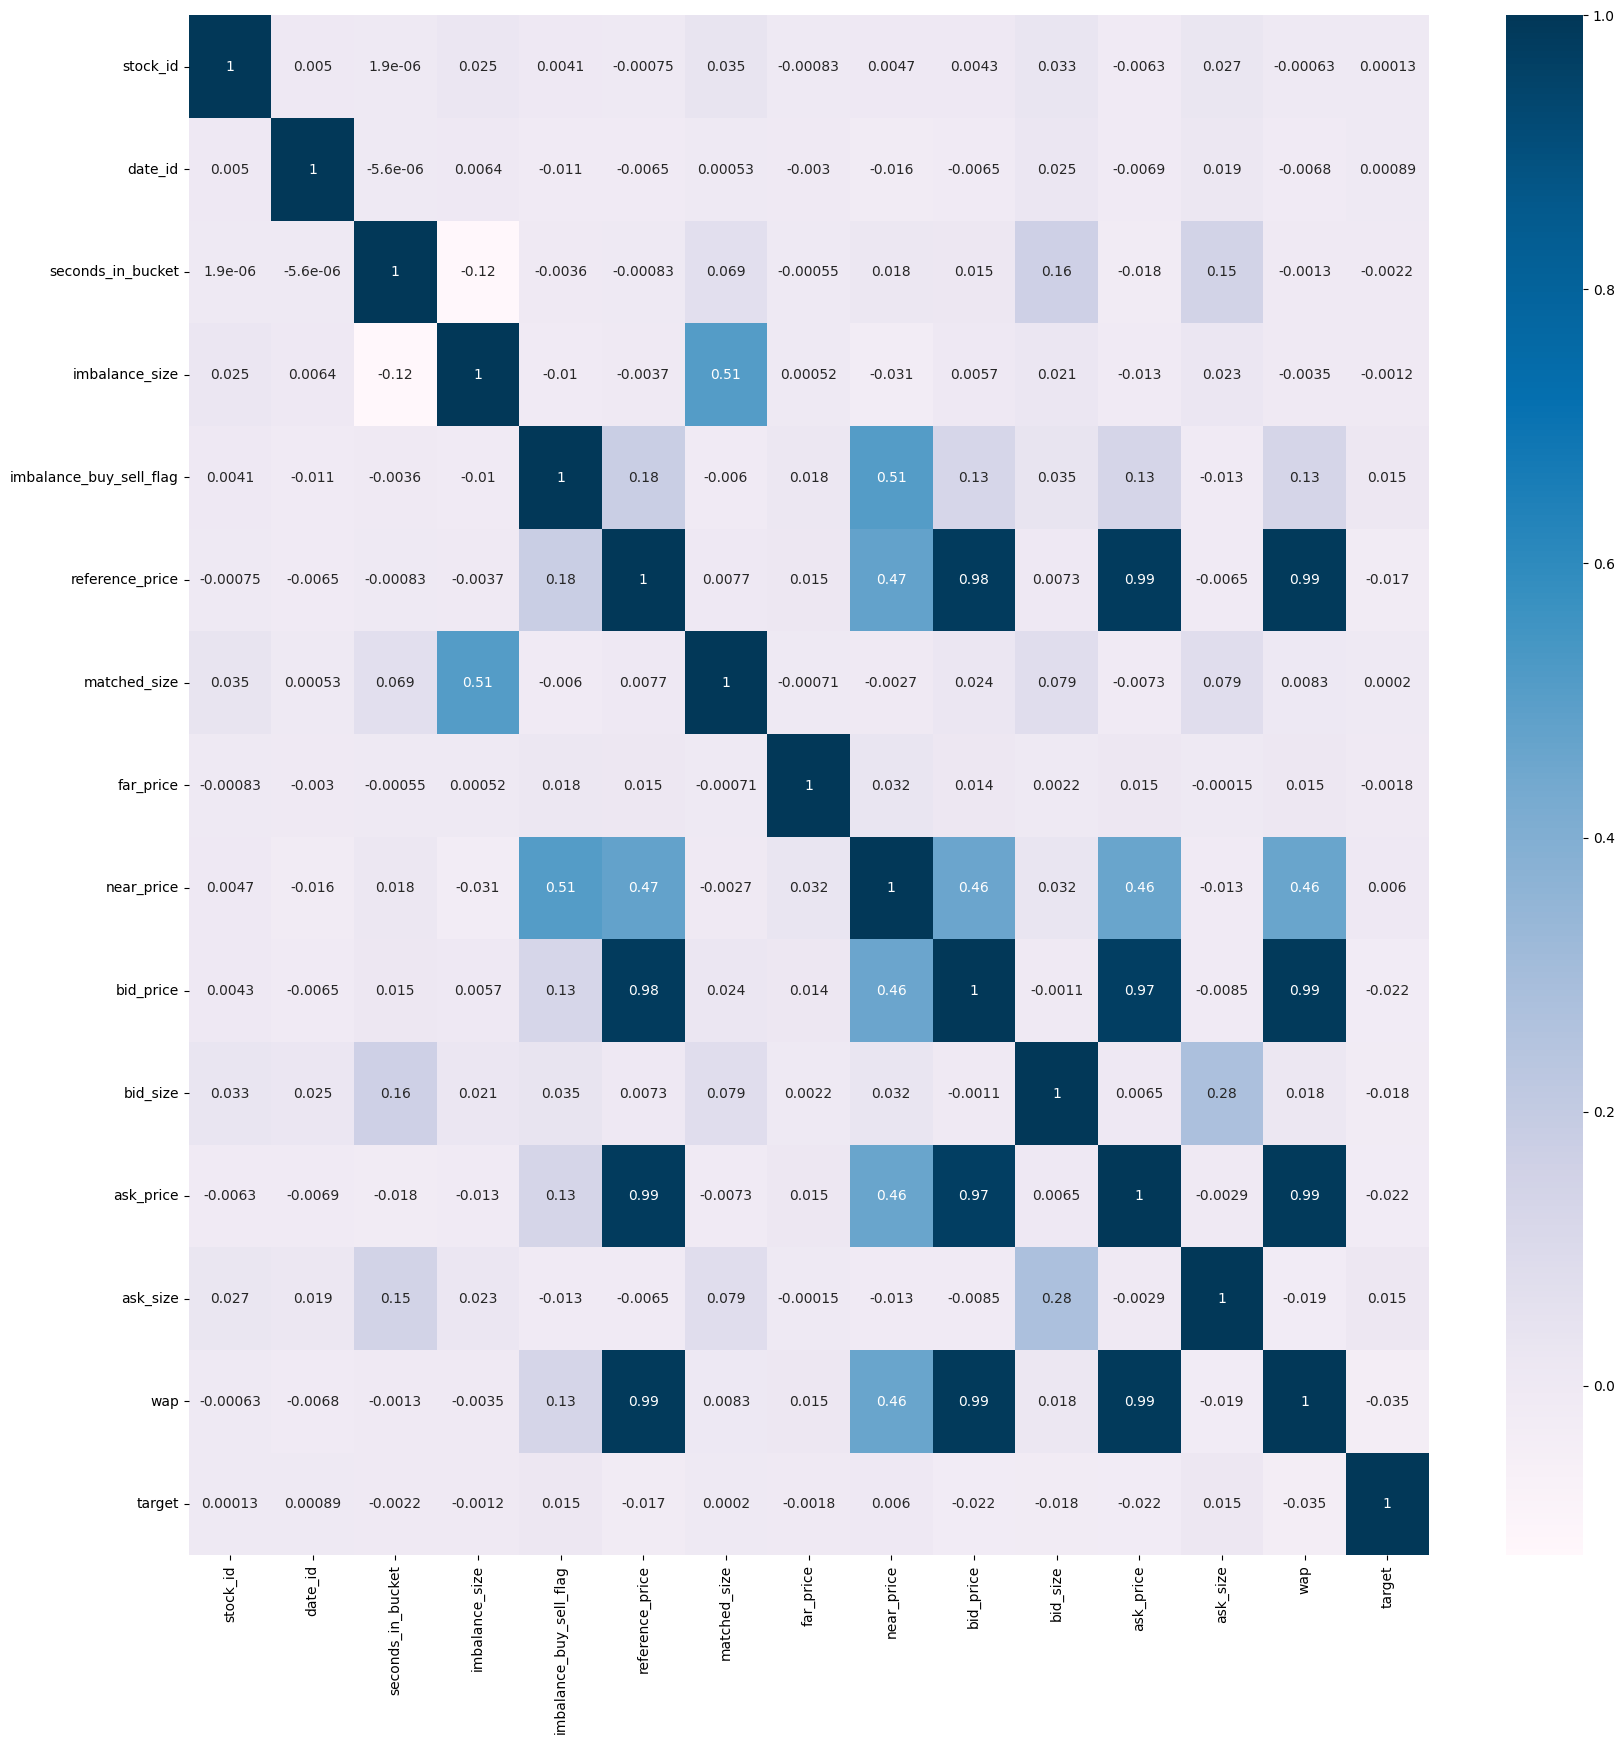

In [78]:
# Set figure size
plt.figure(figsize=(20, 20))

# Calculate correlation matrix
cor = df.corr() 

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

## Filter Methods

Let's start feature selection with filter methods. This type of feature selection uses statistical methods to rank a given set of features. Moreover, it does this ranking regardless of the model you will be training on (i.e. you only need the feature values). When using these, it is important to note the types of features and target variable you have. Here are a few examples:

* Pearson Correlation (numeric features - numeric target, *exception: when target is 0/1 coded*)
* ANOVA f-test (numeric features - categorical target, not the case in here)
* Chi-squared (categorical features - categorical target, not the case in here)

Let's the Pearson Correlation analysis in the following cells. 

### Correlation with the target variable

Let's start by determining which features are strongly correlated with the target. Since we have numeric features and our target, we can use Pearson correlation to compute the scores for each feature. This is also categorized as *supervised* feature selection because we're taking into account the relationship of each feature with the target variable. Moreover, since only one variable's relationship to the target is taken at a time, this falls under *univariate feature selection*.

The problem in here is that no feature looks to correlate enough with the target.

In [79]:
# Get the absolute value of the correlation
cor_target = abs(cor["target"])

# Select highly correlated features (thresold = 1e-6). Select all because none seems to be correlated.
relevant_features = cor_target[cor_target > 1e-6]

# Collect the names of the features
names = [index for index, value in relevant_features.items()]

# Drop the target variable from the results
names.remove("target")

# Display the results
print(names)

['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']


Now try training the model again but only with the features in the columns you just gathered. You can observe that there is an improvement in the metrics compared to the model you trained earlier.

In [80]:
# Evaluate the model with new features
strong_features_eval_df = evaluate_model_on_features(df[names], Y)
strong_features_eval_df.index = ["Strong features"]

# Append to results and display
results = pd.concat([results, strong_features_eval_df])
results.head()

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 14
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (63.94 MB) transferred to GPU in 0.122906 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


,MAE,MSE,SMAPE,Feature Count
All features,5.990341,79.599016,162.76387,14
Strong features,5.990341,79.599016,162.76387,14


### Correlation with other features

You will now eliminate features which are highly correlated with each other. This helps remove redundant features thus resulting in a simpler model. Since the scores are calculated regardless of the target variable, this can be categorized under *unsupervised* feature selection.

For this, you will plot the correlation matrix of the features selected previously. Let's first visualize the correlation matrix again.

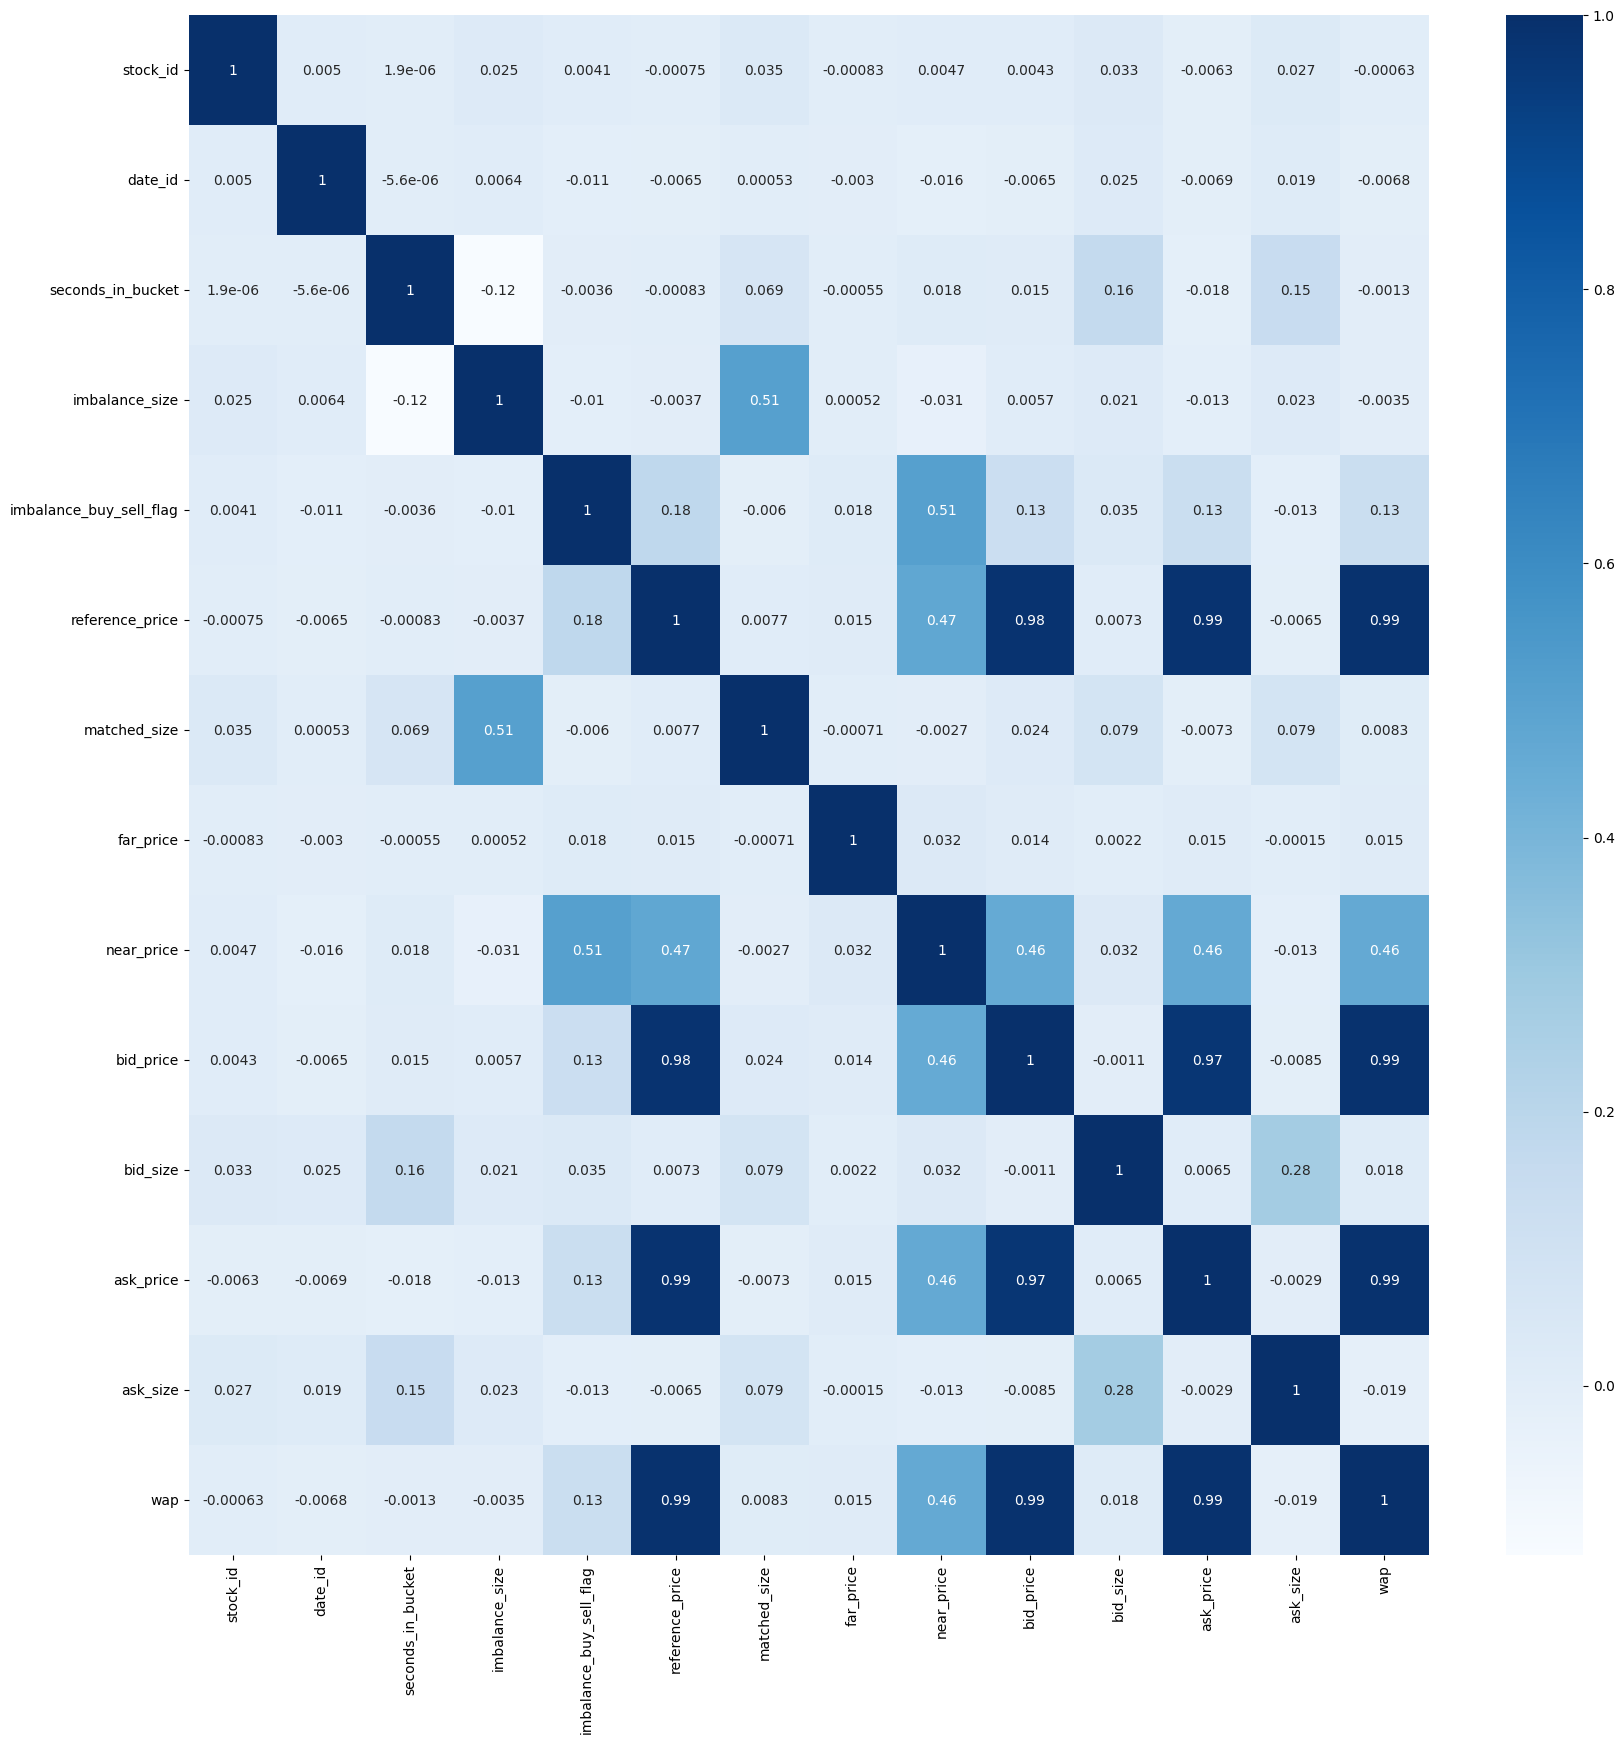

In [81]:
# Set figure size
plt.figure(figsize=(20, 20))

# Calculate the correlation matrix for target relevant features that you previously determined
new_corr = df[names].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

You will see that `wap` is highly correlated to `reference_price`, `bid_price`, and `ask_price`. You can retain any of these and remove the rest of the features highly correlated to it.


This is a more magnified view of the features that are highly correlated to each other.

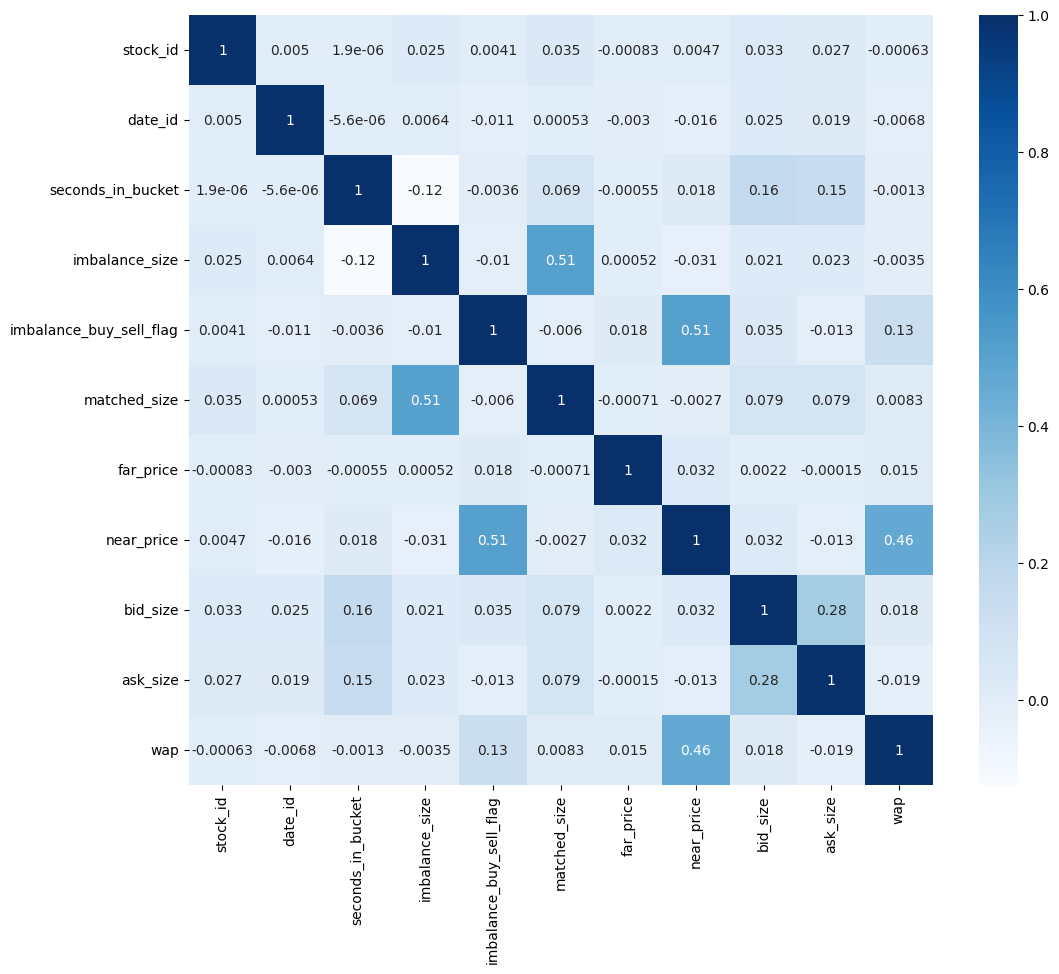

In [82]:
# Set figure size
plt.figure(figsize=(12, 10))

# Select a subset of features
new_corr = df[["stock_id", "date_id", "seconds_in_bucket", "imbalance_size", "imbalance_buy_sell_flag", "matched_size", "far_price", "near_price",
               "bid_size", "ask_size", "wap"]].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

You will now evaluate the model on the features selected based on your observations. You can see that the metrics show the same values as when it was using 25 features. This indicates that you can get the same model performance even if you reduce the number of features. In other words, the 4 features you removed were indeed redundant and you only needed the ones you retained.

In [83]:
# Remove the features with high correlation to other features
subset_feature_corr_names = [x for x in names if x not in ["reference_price", "bid_price", "ask_price"]]

# Calculate and check evaluation metrics
subset_feature_eval_df = evaluate_model_on_features(df[subset_feature_corr_names], Y)
subset_feature_eval_df.index = ["Subset features"]

# Append to results and display
results = pd.concat([results, subset_feature_eval_df])
results.head(n=10)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 11
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (47.95 MB) transferred to GPU in 0.097495 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


,MAE,MSE,SMAPE,Feature Count
All features,5.990341,79.599016,162.763870,14
Strong features,5.990341,79.599016,162.763870,14
Subset features,6.007946,79.980581,163.401882,11


## Wrapper Methods

Wrapper methods use a model to measure the effectiveness of a particular subset of features. One approach is to remove or add features sequentially. You can either start with 1 feature and gradually add until no improvement is made (forward selection), or do the reverse (backward selection). That can be done with the [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) class which uses k-fold cross validation scores to decide which features to add or remove. [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is similar to backwards elimination but uses feature importance scores to prune the number of features. You can also specify how many features to remove at each iteration of the recursion. Let's use this as the wrapper for our model below.

### Recursive Feature Elimination

You used the **LGBMRegressor** as the model algorithm for which features should be selected. Now, it is high time to use **Recursive Feature Elimination**, which wraps around the selected model to perform feature selection. This time, you can repeat the same task of selecting the top 10 features using RFE.

In [84]:
def run_rfe(x, y):
    
    # Since y is numerical, stratification in train-test split needs from binning target variable
    if CFG.STRATIFY:
        bins = np.linspace(np.floor(y.min()), np.ceil(y.max()), 10)
        y_binned = np.digitize(y, bins)
    else:
        y_binned = None

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=1./CFG.N_FOLDS, stratify=y_binned, random_state=CFG.RANDOM_STATE, shuffle=not CFG.TIME_AWARE_SPLIT)

    # All features of dataset are float values. You normalize all features of the train and test dataset here (not necessary with decission trees)
    if CFG.SCALE:
        scaler = CFG.SCALER()
        scaler = scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)

    # Define the model
    model = CFG.MODEL(**CFG.MODEL_CONFIG)
    
    # Wrap RFE around the model
    rfe = RFE(model, n_features_to_select=CFG.RFE_FEAT_COUNT)
    
    # Fit RFE
    rfe = rfe.fit(x_train, y_train)
    feature_names = df.drop(columns=["target"]).columns[rfe.get_support()]
    
    return feature_names

In [85]:
rfe_feature_names = run_rfe(X, Y)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 14
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (63.94 MB) transferred to GPU in 0.099371 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2796
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 13
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8


Now it is high time to evaluate the **LGBMRegressor** on the features selected by RFE. In this case, you will see that there is a slight performance increase compared to the previous approaches.

In [86]:
# Calculate and check model metrics
rfe_eval_df = evaluate_model_on_features(df[rfe_feature_names], Y)
rfe_eval_df.index = ["RFE"]

# Append to results and display
results = pd.concat([results, rfe_eval_df])
results.head(n=10)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 10
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (47.95 MB) transferred to GPU in 0.078411 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


,MAE,MSE,SMAPE,Feature Count
All features,5.990341,79.599016,162.763870,14
Strong features,5.990341,79.599016,162.763870,14
Subset features,6.007946,79.980581,163.401882,11
RFE,5.989565,79.589274,164.069257,10


## Embedded Methods

Some models already have intrinsic properties that select the best features when it is constructed. With that, you can simply access these properties to get the scores for each feature. Let's look at some examples in the following sections.

### Feature Importances

**Feature importance** is already built-in in scikit-learn’s tree based models like **RandomForestClassifier** and typical gradient boosting algorithms such as **LGBMRegressor**. Once the model is fit, the feature importance is available as a property named **feature_importances_**.

One can simply use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to select features from the trained model based on a given threshold.

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 14
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (63.94 MB) transferred to GPU in 0.110928 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


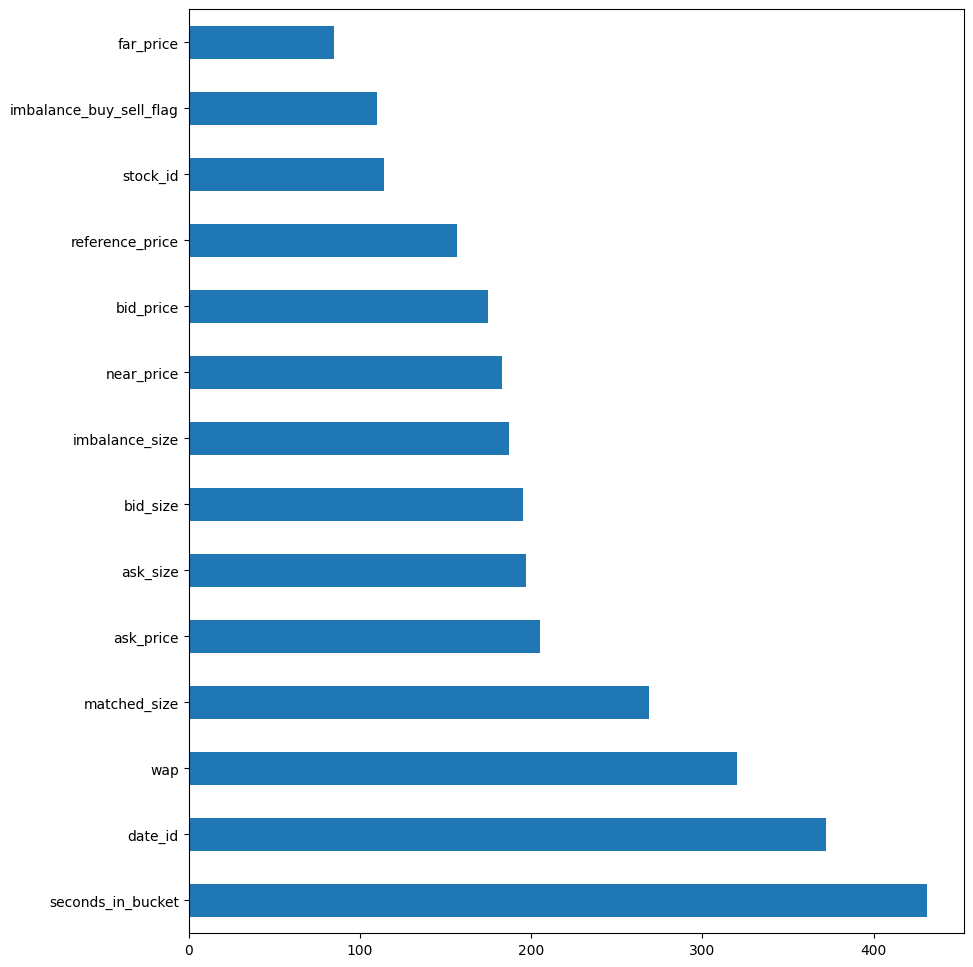

In [87]:
def feature_importances_from_tree_based_model(x, y):
    
    # Since y is binned, stratification in train-test split needs from binning target variable
    if CFG.STRATIFY:
        bins = np.linspace(np.floor(y.min()), np.ceil(y.max()), 10)
        y_binned = np.digitize(y, bins)
    else:
        y_binned = None

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=1./CFG.N_FOLDS, stratify=y_binned, random_state=CFG.RANDOM_STATE, shuffle=not CFG.TIME_AWARE_SPLIT)

    # All features of dataset are float values. You normalize all features of the train and test dataset here (not necessary with decission trees)
    if CFG.SCALE:
        scaler = CFG.SCALER()
        scaler = scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)
    
    # Make sure the configured model supports feature importance or this will fail
    model = fit_model(x_train, y_train)
    
    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()
    
    return model


def select_features_from_model(model):
    
    model = SelectFromModel(model, prefit=True, max_features=CFG.FEAT_FIMPORT_COUNT)
    feature_idx = model.get_support()
    feature_names = df.drop(columns=["target"]).columns[feature_idx]
        
    return feature_names

model = feature_importances_from_tree_based_model(X, Y)
feature_imp_feature_names = select_features_from_model(model)

In [88]:
# Calculate and check model metrics
feat_imp_eval_df = evaluate_model_on_features(df[feature_imp_feature_names], Y)
feat_imp_eval_df.index = ["Feature Importance"]

# Append to results and display
results = pd.concat([results, feat_imp_eval_df])
results.head(n=10)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 4
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (15.98 MB) transferred to GPU in 0.039733 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


,MAE,MSE,SMAPE,Feature Count
All features,5.990341,79.599016,162.763870,14
Strong features,5.990341,79.599016,162.763870,14
Subset features,6.007946,79.980581,163.401882,11
RFE,5.989565,79.589274,164.069257,10
Feature Importance,6.083263,81.440831,168.252847,4


With these results and also domain knowledge, one can decide which set of features to use to train on the entire dataset, and withted methods. Due to its robustness to outliers and invariance to dependent variable magnitude, the decision will be based on the MAE metric. 

## Wrap Up

That's it for this quick rundown of different feature selection methods applicable to regression problems such as the Trading-at-the-Close problem. As shown, you can do quick experiments with these because convenience modules are already available in libraries like sci-kit learn. It is a good idea to do this preprocessing step because not only will you save resources, you may even get better results than when you use all features.